In [2]:
import numpy as np
import pandas as pd

import syndat.dt_null_encoder as dt_null_encoder
import syndat.data_generator as sdg

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# create test df with continuous, categorical, and date/time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_int = np.random.randint(0, 10, size=n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_int': x_int, 'x_categ':x_categ, 'x_date':x_date}
)

# convert dt to str to make the data more realistic
df['x_date'] = df['x_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,0.785733,0.763638,6,c3,2009-08-05
1,1.314424,0.812481,1,c2,2009-05-06
2,-0.165295,0.829847,4,c3,2009-11-26
3,0.202155,0.375992,7,c1,2009-01-31
4,0.152412,0.664950,7,c2,2016-12-09


In [4]:
# inject NAs
n_na = int(len(df)/100)
for c in df.columns:
    df.loc[np.random.choice(np.arange(len(df)), n_na), c] = np.nan
df.isnull().sum()

x_norm     100
x_unif     100
x_int      100
x_categ     99
x_date      99
dtype: int64

In [5]:
cols = {
    'x_norm':'float',
    'x_unif':'float',
    'x_int':'int',
    'x_categ':'unord',
    'x_date':'dt'
}

# Synthetic data generation

In [6]:
# dt na encoding
df_orig = df.copy() # need df_orig for decoding dt nulls
df = dt_null_encoder.encode(df, cols)

In [7]:
df.isnull().sum()

x_norm     100
x_unif     100
x_int      100
x_categ     99
x_date       0
dtype: int64

## Multivariate density estimation and sampling

In [8]:
# the multivariate approach cannot hadnle NAs in int and float columns.
# impute NAs before calling syndat
df_imp = df.copy()

# replace NAs with 0 for now - can do "better", e.g., replace with median
df_imp[['x_norm', 'x_unif', 'x_int']] = df_imp[['x_norm', 'x_unif', 'x_int']] .fillna(0)

df_imp.isnull().sum()

x_norm      0
x_unif      0
x_int       0
x_categ    99
x_date      0
dtype: int64

In [9]:
sd = sdg.DataGenerator(df_imp, cols, multivariate=True, convert_dt=True)

/home/aras/.venv/syndat/lib64/python3.10/site-packages/syndat/data_generator.py:49: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.df = data[cols].copy()


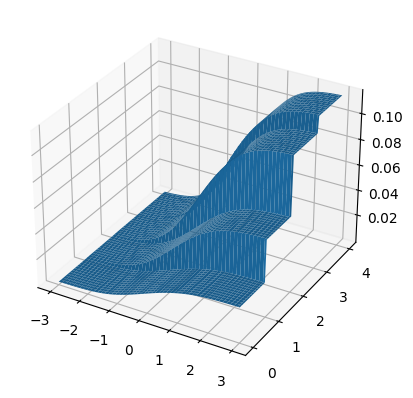

In [13]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_int_samp = np.median(sd.df['x_int'])
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,x_int_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

Note that the fourth category corresponds to NAs

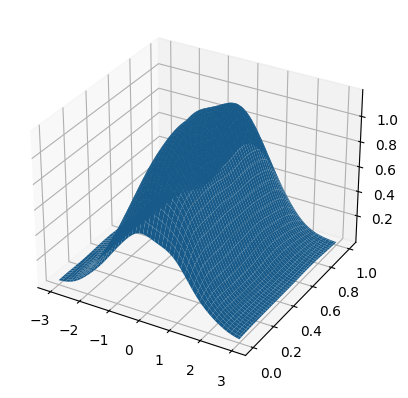

In [14]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
x_int_samp = np.median(sd.df['x_int'])
x_categ_samp = 2
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_int_samp,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [15]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

In [16]:
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,-1.701270,0.789909,1,c3,2011-05-13
1,-1.730528,0.549044,2,c2,1980-06-10
2,2.110440,0.350134,1,c3,2007-01-16
3,0.021782,0.820911,0,c3,2019-05-18
4,0.945273,0.303067,8,c2,1992-05-03


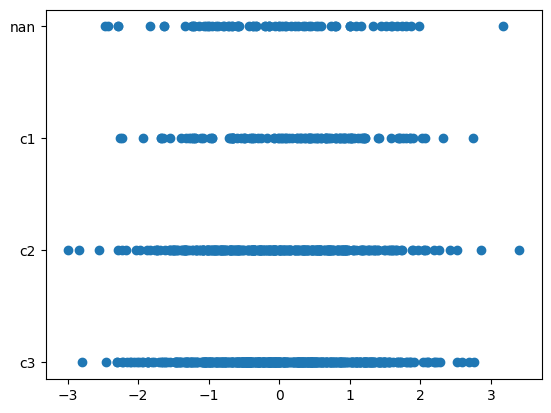

In [17]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

Note the addition of the nan category. If desired, NAs can be imputed before calling syndat

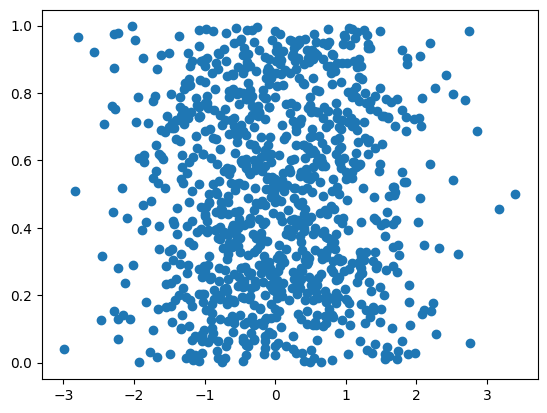

In [18]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

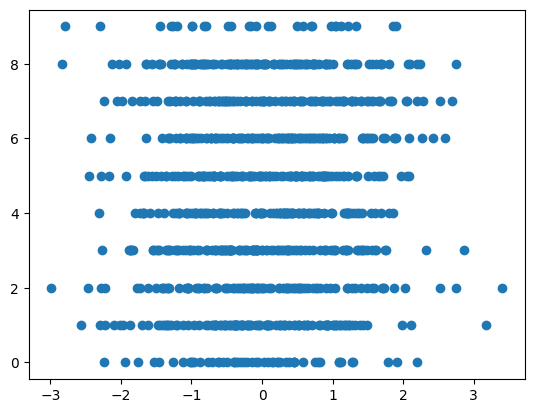

In [19]:
# plot sampled data - normal vs int uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_int'])

## Univariate density estimation and sampling

In [20]:
# unlike the multivariate approach, the univariate approach
# does not break if there are NAs in float cols
# the UV KDE can also handle NAs in int columns, but sampling
# breaks since int type does not support nan
df.isnull().sum()

x_norm     100
x_unif     100
x_int      100
x_categ     99
x_date       0
dtype: int64

In [21]:
df['x_int'] = df['x_int'].fillna(0)

In [22]:
sd = sdg.DataGenerator(df, cols, multivariate=False, convert_dt=True)

/home/aras/.venv/syndat/lib64/python3.10/site-packages/syndat/data_generator.py:49: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.df = data[cols].copy()


In [23]:
df_samp = sd.get_sample(n=1000)
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,-2.545441,0.825355,7,c3,2012-09-18
1,-1.452275,0.290135,5,c3,2008-04-30
2,-0.506834,0.932859,7,c3,2009-08-02
3,0.246171,0.095828,0,c2,2001-05-03
4,0.403263,0.308068,9,c1,2010-11-15


In [24]:
df_samp.isnull().sum()

x_norm     9
x_unif     6
x_int      0
x_categ    0
x_date     0
dtype: int64

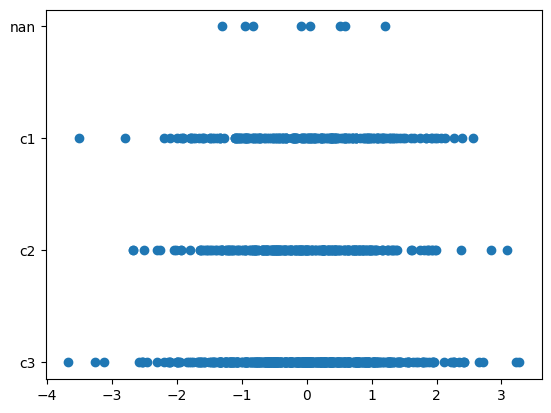

In [25]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

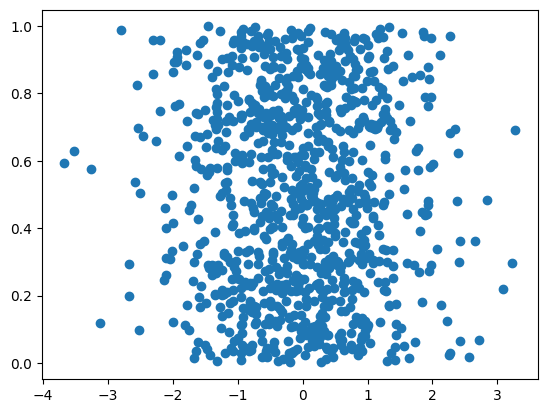

In [26]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

# Encoding categorical variables (e.g., for masking the real data)

In [27]:
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,-2.545441,0.825355,7,c3,2012-09-18
1,-1.452275,0.290135,5,c3,2008-04-30
2,-0.506834,0.932859,7,c3,2009-08-02
3,0.246171,0.095828,0,c2,2001-05-03
4,0.403263,0.308068,9,c1,2010-11-15


In [30]:
import syndat.label_encoder as label_encoder

le_grp_dict = {
    'categ': [df_samp['x_categ']]
}

le_dict = {
    'categ': ['x_categ']
}

le = label_encoder.LabelEncoder(le_grp_dict)
df_samp = le.encode(df_samp, le_dict)
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,-2.545441,0.825355,7,2,2012-09-18
1,-1.452275,0.290135,5,2,2008-04-30
2,-0.506834,0.932859,7,2,2009-08-02
3,0.246171,0.095828,0,1,2001-05-03
4,0.403263,0.308068,9,0,2010-11-15


In [32]:
# adding prefix to the encoded categories
prefix_dict = {
    'x_categ': 'cat'
}

df_samp = label_encoder.add_prefix(df_samp, prefix_dict)

df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,-2.545441,0.825355,7,cat2,2012-09-18
1,-1.452275,0.290135,5,cat2,2008-04-30
2,-0.506834,0.932859,7,cat2,2009-08-02
3,0.246171,0.095828,0,cat1,2001-05-03
4,0.403263,0.308068,9,cat0,2010-11-15
